# Datasets Creation for finetuning LLM

# 1. Loading and analyzing the dataset

#### Dataset info  :
This dataset is focused on improving LLM logical reasoning skills and was used to train the Platypus2 models. It is comprised of the following datasets, which were filtered using keyword search and then Sentence Transformers to remove questions with a similarity above 80%:  

In [ ]:
#@ Installing libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu

In [2]:
#@ providing hugging face tokens
from google.colab import userdata

# Defined in the secrets tab in Google Colab
hf_token = userdata.get('huggingface')

In [ ]:
#@ Loading datasets
from datasets import load_dataset

dataset = load_dataset("garage-bAInd/Open-Platypus")
dataset

In [ ]:
#@ converting dataset into pandas dataframe
dataset['train'].to_pandas()

In [ ]:
#@ Plotting the token counts
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

# 2. Filetring out rows with more than 2048 tokens

We can remove samples with more than 2048 tokens for finetuning Mistral 7B with max context size of 4096

Number of valid rows: 24896
Removing 30 rows...


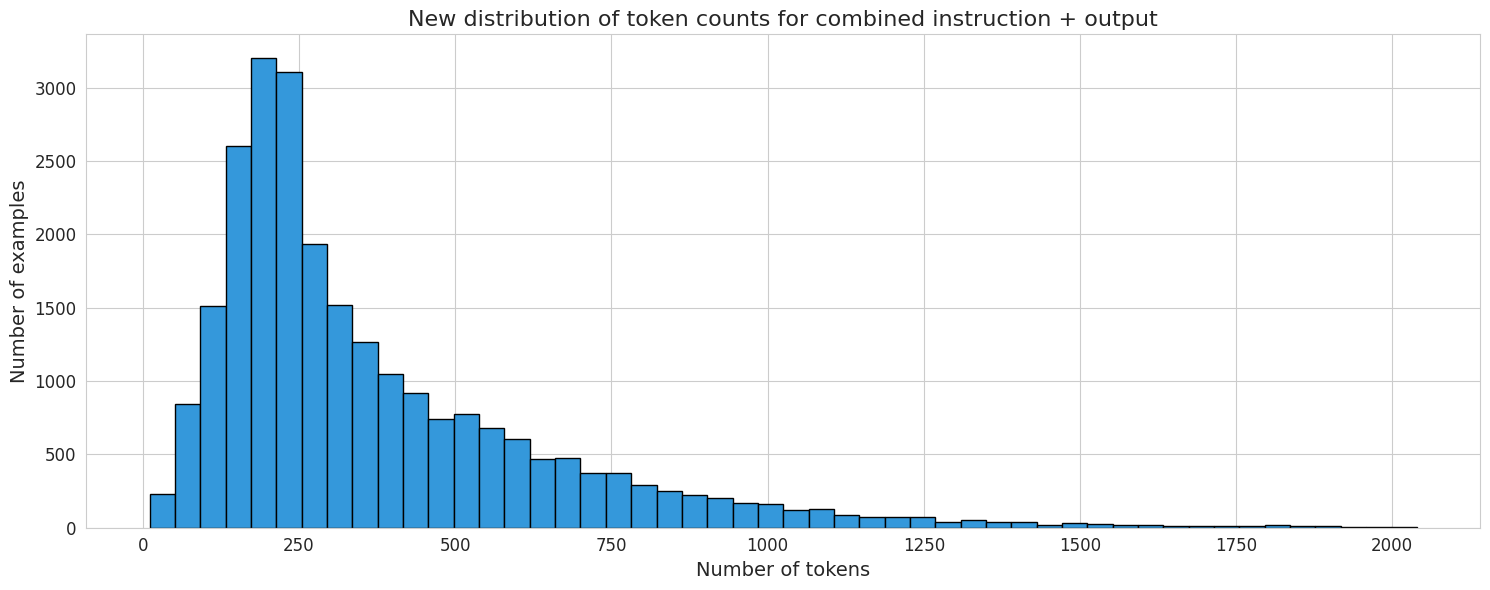

In [6]:
# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset['train'] = dataset['train'].select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")

# 3. Near deduplication using embeddings
Removing samples with similar embeddings like upto 0.95

In [ ]:
#@ Removing samples with similar output using embeddings

from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    ## loading embeddings
    sentence_model = SentenceTransformer(model)
    ## loading output datasets
    outputs = [example["output"] for example in dataset['train']]

    print("Converting text to embeddings...")
    ## convert output to embeddings and normalize
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

In [8]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}")

Number of samples in the original dataset: 24896
Number of samples in the deduped dataset: 18159
Number of samples that were removed: 6737


# 4. Top k sampling
Only keeping sample with most tokens i.e top k

In [9]:
#@ Keeping only top k sample here k =1000 means we keep 1000 sample with highest token counts
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "instruction": [dataset['train'][i]["instruction"] for i in top_k_indices],
        "output": [dataset['train'][i]["output"] for i in top_k_indices]
    }

    return Dataset.from_dict(top_k_data)

# Get token counts
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in deduped_dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in deduped_dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 1000  # You can adjust this value as needed
top_k_dataset = get_top_k_rows(deduped_dataset, combined_token_counts, k)

# Save these rows in a Dataset object with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

In [10]:
dataset['train'].to_pandas()


,instruction,output
0,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
1,"Given the code below, refactor it, add comment...",Here is the refactored and commented version:\...
2,Your task is to generate a unique piece of sho...,Title: The Last Expedition\n\nThe barren waste...
3,Find the area of the region described by $x \g...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,Develop a Node.js REST API that interacts with...,To create a Node.js REST API that interacts wi...
...,...,...
995,"The setting is a cozy living room, where three...","Charles Darwin: ""Did you know that there are o..."
996,There exists a scalar $k$ such that for any ve...,This problem involves vectors and cross produc...
997,What is the ratio of the area of the shaded sq...,Divide the square into $16$ smaller squares as...
998,A sphere is inscribed in a cube with edge leng...,We draw a diagram:\n\n[asy]\nsize(140);\ndraw(...


# 5. Chat templates
Defining chat template , in formats the instructions  and responses are suitable for model.

In [ ]:
#@ specifying chattemplate accoriding to model
def chat_template(example):
    example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

In [14]:
dataset['train'].to_pandas()

,instruction,output
0,"### Instruction:\nLet\n$$p(x,y) = a_0 + a_1x +...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
1,"### Instruction:\nGiven the code below, refact...",Here is the refactored and commented version:\...
2,### Instruction:\nYour task is to generate a u...,Title: The Last Expedition\n\nThe barren waste...
3,### Instruction:\nFind the area of the region ...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,### Instruction:\nDevelop a Node.js REST API t...,To create a Node.js REST API that interacts wi...
...,...,...
995,### Instruction:\nThe setting is a cozy living...,"Charles Darwin: ""Did you know that there are o..."
996,### Instruction:\nThere exists a scalar $k$ su...,This problem involves vectors and cross produc...
997,### Instruction:\nWhat is the ratio of the are...,Divide the square into $16$ smaller squares as...
998,### Instruction:\nA sphere is inscribed in a c...,We draw a diagram:\n\n[asy]\nsize(140);\ndraw(...


In [ ]:
#@ pushing datasets to hugging face
dataset.push_to_hub("mini-platypus", token=hf_token)